In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import SimpleITK as sitk
import numpy as np

In [4]:
def load_image(nifti_file):
    """Load a NIfTI image file and return the image data."""
    nifti_data = nib.load(nifti_file)
    image_data = nifti_data.get_fdata()
    return image_data
  
def plot_image(image_data, slice_number=100):
    plt.imshow(image_data[:,:,slice_number], cmap='gray')
    plt.show()


In [10]:
BASE_PATH = Path('./DATA/BIDS')

image_paths = {
    'sub-0001': [
        BASE_PATH / 'sub-0001/anat/sub-0001_acq-FLAIRSAG3D_T1w.nii.gz',
        BASE_PATH / 'sub-0001/anat/sub-0001_acq-SAG3DT1ACCELERATED_T1w.nii.gz'
    ],
    'sub-0002': [
        BASE_PATH / 'sub-0002/anat/sub-0002_acq-FLAIRSAG3D_T1w.nii.gz',
        BASE_PATH / 'sub-0002/anat/sub-0002_acq-SAG3DT1ACCELERATED_T1w.nii.gz'
    ],
    'sub-0003': [
        BASE_PATH / 'sub-0003/anat/sub-0003_acq-SAGT1SE_echo-1_T1w.nii.gz'
    ],
    'sub-0004': [
        BASE_PATH / 'sub-0004/anat/sub-0004_acq-AXT2_T1w.nii.gz'
    ],
    'sub-0005': [
        BASE_PATH / 'sub-0005/anat/sub-0005_acq-T2COR_T1w.nii.gz'
    ]
}

loaded_images = {}
for subject_id, paths_list in image_paths.items():
    loaded_images[subject_id] = []
    for i, file_path in enumerate(paths_list):
        try:
            image_data = load_image(file_path)
            loaded_images[subject_id].append(image_data)
            print(f"Successfully loaded {subject_id} - image {i+1}")
        except Exception as e:
            print(f"Error loading {subject_id} - image {i+1}: {e}")
            loaded_images[subject_id].append(None)

Successfully loaded sub-0001 - image 1
Successfully loaded sub-0001 - image 2
Successfully loaded sub-0002 - image 1
Successfully loaded sub-0002 - image 2
Successfully loaded sub-0003 - image 1
Successfully loaded sub-0004 - image 1
Successfully loaded sub-0005 - image 1


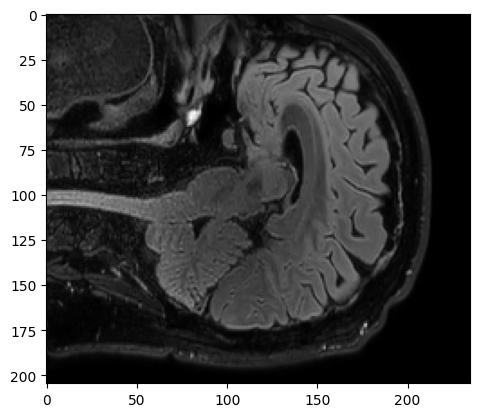

In [11]:
plot_image(loaded_images['sub-0001'][0], slice_number=100)

In [12]:
def anisotropic_diffusion_sitk(image_array, 
                               timeStep=0.125, 
                               numberOfIterations=5, 
                               conductanceParameter=3.0):
    """ Apply anisotropic diffusion to the image using SimpleITK """
    image = sitk.GetImageFromArray(image_array)
    
    filtered = sitk.CurvatureAnisotropicDiffusion(
        image,
        timeStep=timeStep,
        numberOfIterations=numberOfIterations,
        conductanceParameter=conductanceParameter
    )
    
    return sitk.GetArrayFromImage(filtered)
  
def gradient_anisotropic_diffusion_sitk(image_data, 
                                        timeStep=0.125, 
                                        numberOfIterations=5, 
                                        conductanceParameter=3.0):
    """Apply gradient anisotropic diffusion to the image using SimpleITK."""
    sitk_image = sitk.GetImageFromArray(image_data.astype('float32'))
    filtered = sitk.GradientAnisotropicDiffusion(sitk_image, 
                                                  timeStep=timeStep, 
                                                  numberOfIterations=numberOfIterations, 
                                                  conductanceParameter=conductanceParameter)
    return sitk.GetArrayFromImage(filtered)
  
def median_filter_sitk(image_data, radius=(1, 1, 2)):
    """Apply anisotropic median filter (different radius per dimension)."""
    sitk_image = sitk.GetImageFromArray(image_data.astype('float32'))
    filtered = sitk.Median(sitk_image, radius)
    return sitk.GetArrayFromImage(filtered)

In [13]:
def plot_mri_comparison(rows_data, slice_idx=None, figsize=None, cmap='gray', 
                       suptitle=None, title_fontsize=10, show_axes=False):
    """
    Plot multiple MRI images in a dynamic grid layout.
    
    Parameters:
    -----------
    rows_data : list of lists
        Each inner list represents a row in the figure.
        Each element should be a dictionary with keys:
        - 'image': 3D numpy array (the MRI volume)
        - 'title': string (title for the subplot)
    slice_idx : int or None
        Which slice to display. If None, uses middle slice.
    figsize : tuple or None
        Figure size (width, height). If None, calculated automatically.
    cmap : str
        Colormap for displaying images.
    suptitle : str or None
        Overall title for the entire figure.
    title_fontsize : int
        Font size for subplot titles.
    show_axes : bool
        Whether to show axes ticks and labels.
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    
    n_rows = len(rows_data)
    n_cols = max(len(row) for row in rows_data) if rows_data else 0
    
    if n_rows == 0 or n_cols == 0:
        raise ValueError("No data provided")
    
    if figsize is None:
        fig_width = n_cols * 4
        fig_height = n_rows * 4
        figsize = (fig_width, fig_height)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, row_data in enumerate(rows_data):
        for col_idx, plot_data in enumerate(row_data):
            ax = axes[row_idx, col_idx]
            
            image = plot_data['image']
            if slice_idx is None:
                current_slice_idx = image.shape[2] // 2
            else:
                current_slice_idx = min(slice_idx, image.shape[2] - 1)
            
            im = ax.imshow(image[:, :, current_slice_idx], cmap=cmap, origin='lower')
            ax.set_title(plot_data['title'], fontsize=title_fontsize)
            
            if not show_axes:
                ax.set_xticks([])
                ax.set_yticks([])
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        for col_idx in range(len(row_data), n_cols):
            axes[row_idx, col_idx].set_visible(False)
    
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=0.98)
    
    plt.tight_layout()
    
    return fig, axes
  
def create_plot_data(image, title):
  """Helper function to create plot data dictionary."""
  return {'image': image, 'title': title}

CurvatureAnisotropicDiffusionImageFilter (0x106fdee70): Anisotropic diffusion unstable time step: 0.6
Stable time step for this image must be smaller than 0.0625

CurvatureAnisotropicDiffusionImageFilter (0x106fdee70): Anisotropic diffusion is using a time step which may introduce instability into the solution.



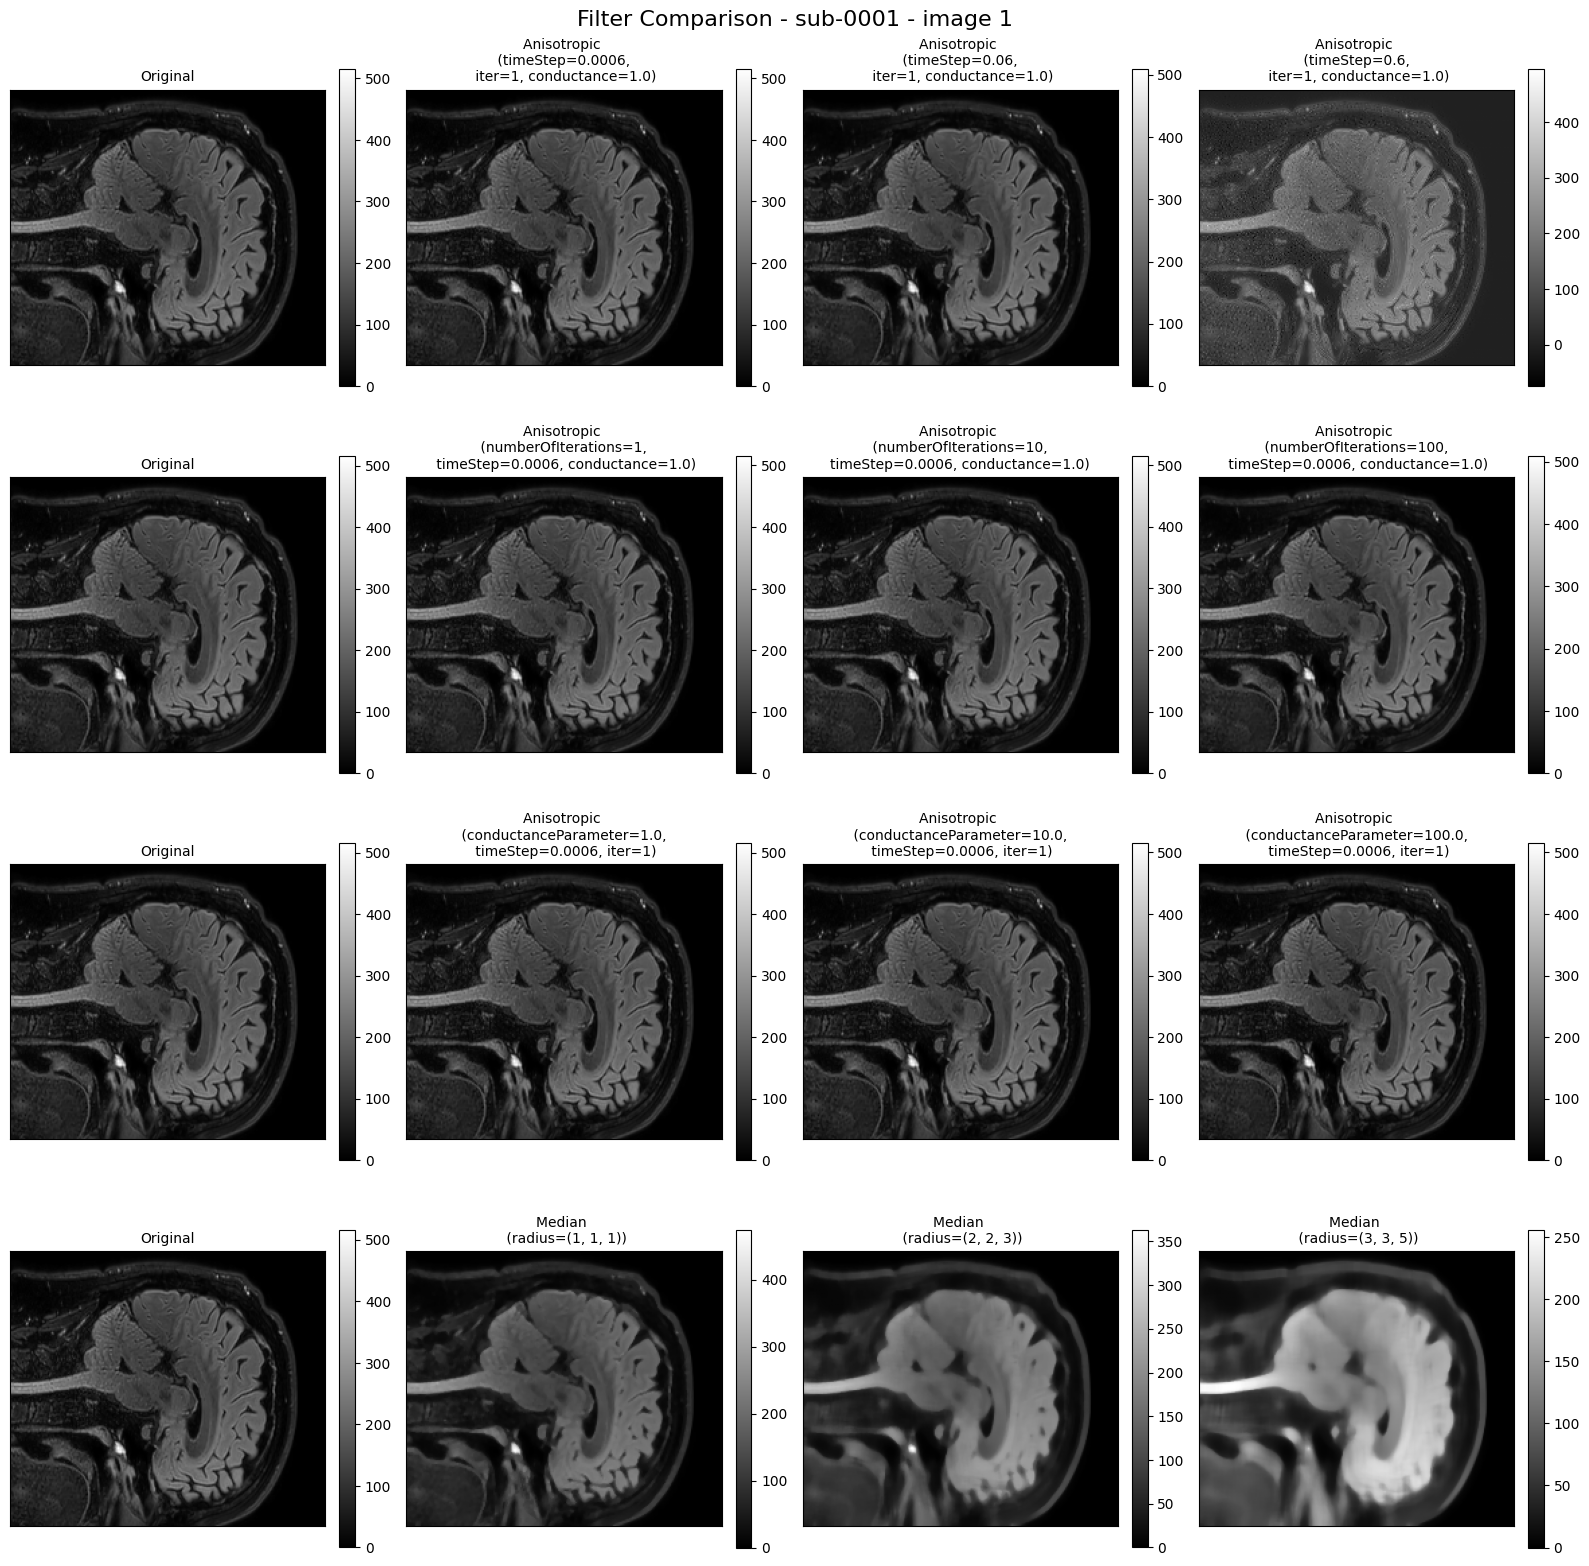

In [14]:
def sub_0001_img_1_filter_comparison(subject_id='sub-0001', image_idx=0):
    """Example showing different filters applied to the same image."""
    
    original = loaded_images[subject_id][image_idx]
    
    TIME_STEP_1 = 0.0006
    TIME_STEP_2 = 0.06
    TIME_STEP_3 = 0.6
    
    NUMBER_OF_ITERATIONS_1 = 1
    NUMBER_OF_ITERATIONS_2 = 10
    NUMBER_OF_ITERATIONS_3 = 100
    
    CONDUCTANCE_PARAMETER_1 = 1.0
    CONDUCTANCE_PARAMETER_2 = 10.0
    CONDUCTANCE_PARAMETER_3 = 100.0
    
    
    aniso_time_step_1 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    aniso_time_step_2 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_2, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    aniso_time_step_3 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_3, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    aniso_iter_1 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    aniso_iter_2 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_2, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    
    aniso_iter_3 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_3, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    aniso_conductance_1 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_1)
    
    
    aniso_conductance_2 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_2)
    
    
    aniso_conductance_3 = anisotropic_diffusion_sitk(original,
                                            timeStep=TIME_STEP_1, 
                                            numberOfIterations=NUMBER_OF_ITERATIONS_1, 
                                            conductanceParameter=CONDUCTANCE_PARAMETER_3)
    
    row1 = [
        create_plot_data(original, 'Original'),
        create_plot_data(aniso_time_step_1, f'Anisotropic \n (timeStep={TIME_STEP_1}, \n iter={NUMBER_OF_ITERATIONS_1}, conductance={CONDUCTANCE_PARAMETER_1})'),
        create_plot_data(aniso_time_step_2, f'Anisotropic \n (timeStep={TIME_STEP_2}, \n iter={NUMBER_OF_ITERATIONS_1}, conductance={CONDUCTANCE_PARAMETER_1})'),
        create_plot_data(aniso_time_step_3, f'Anisotropic \n (timeStep={TIME_STEP_3}, \n iter={NUMBER_OF_ITERATIONS_1}, conductance={CONDUCTANCE_PARAMETER_1})')
    ]
    
    row2 = [
        create_plot_data(original, 'Original'),
        create_plot_data(aniso_iter_1, f'Anisotropic \n (numberOfIterations={NUMBER_OF_ITERATIONS_1}, \n timeStep={TIME_STEP_1}, conductance={CONDUCTANCE_PARAMETER_1})'),
        create_plot_data(aniso_iter_2, f'Anisotropic \n (numberOfIterations={NUMBER_OF_ITERATIONS_2}, \ntimeStep={TIME_STEP_1}, conductance={CONDUCTANCE_PARAMETER_1})'),
        create_plot_data(aniso_iter_3, f'Anisotropic \n (numberOfIterations={NUMBER_OF_ITERATIONS_3}, \n timeStep={TIME_STEP_1}, conductance={CONDUCTANCE_PARAMETER_1})'),
    ]
    
    row3 = [
        create_plot_data(original, 'Original'),
        create_plot_data(aniso_conductance_1, f'Anisotropic \n (conductanceParameter={CONDUCTANCE_PARAMETER_1}, \n timeStep={TIME_STEP_1}, iter={NUMBER_OF_ITERATIONS_1})'),
        create_plot_data(aniso_conductance_2, f'Anisotropic \n (conductanceParameter={CONDUCTANCE_PARAMETER_2}, \n timeStep={TIME_STEP_1}, iter={NUMBER_OF_ITERATIONS_1})'),
        create_plot_data(aniso_conductance_3, f'Anisotropic \n (conductanceParameter={CONDUCTANCE_PARAMETER_3}, \n timeStep={TIME_STEP_1}, iter={NUMBER_OF_ITERATIONS_1})')
    ]
    
    RADIUS_1 = (1, 1, 1)
    RADIUS_2 = (2, 2, 3)
    RADIUS_3 = (3, 3, 5)
    
    
    median_filter_radius_1 = median_filter_sitk(original, radius=RADIUS_1)
    median_filter_radius_2 = median_filter_sitk(original, radius=RADIUS_2)
    median_filter_radius_3 = median_filter_sitk(original, radius=RADIUS_3)
    
    
    row4 = [
        create_plot_data(original, 'Original'),
        create_plot_data(median_filter_radius_1, f'Median \n (radius={RADIUS_1})'),
        create_plot_data(median_filter_radius_2, f'Median \n (radius={RADIUS_2})'),
        create_plot_data(median_filter_radius_3, f'Median \n (radius={RADIUS_3})')
    ]
    
    fig, axes = plot_mri_comparison(
        [row1, row2, row3, row4], 
        slice_idx=100,
        suptitle=f'Filter Comparison - {subject_id} - image {image_idx + 1}'
    )
    
    plt.savefig(f'./plots/sub-{subject_id}_img-{image_idx+1}_filter_comparison.png', dpi=300)
    plt.show()
    return fig, axes

# Run the example
fig, axes = sub_0001_img_1_filter_comparison()